In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models import PlayerXGB
from server.ml_models.player_xgb import PlayerXGBData
from server.data_processors.feature_functions import (
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
)
from server.data_processors import (
    FeatureBuilder,
    PlayerDataStacker,
    OppoFeatureBuilder
)
from server.data_processors import FitzroyDataReader
from src.model.metrics import regression_accuracy, measure_estimators

FEATURE_FUNCS = [
    add_last_year_brownlow_votes,
    add_rolling_player_stats,
    add_cum_matches_played
]
DATA_TRANSFORMERS = [
    PlayerDataStacker().transform,
    FeatureBuilder(
        feature_funcs=FEATURE_FUNCS,
        index_cols=['team', 'year', 'round_number', 'player_id']
    ).transform
]
fitzroy = FitzroyDataReader()
DATA_READERS = [
    fitzroy.get_afltables_stats,
    fitzroy.match_results
]
START_DATE = '1965-01-01'

np.random.seed(42)

def graph_model_history(history):
    acc = history.history['tip_accuracy']
    val_acc = history.history['val_tip_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
def graph_yearly_model_performance(year_data_frame, error=True):
    if error:
        # MAE scores
        plt.figure(figsize=(15, 9))
        sns.barplot(x='year', y='error', hue='model', data=year_data_frame)
        # Not starting axis at 0 to make small relative differences clearer
        plt.ylim(bottom=20)
        plt.title('Model error per season\n', fontsize=18)
        plt.ylabel('MAE', fontsize=14)
        plt.xlabel('', fontsize=14)
        plt.yticks(fontsize=12)
        plt.xticks(fontsize=12)
        plt.legend(fontsize=14)

        plt.show()

    # Accuracy scores
    plt.figure(figsize=(15, 8))
    sns.barplot(x='year', y='accuracy', hue='model', data=year_data_frame)
    # Not starting axis at 0 to make small relative differences clearer
    plt.ylim(bottom=0.55)
    plt.title('Model accuracy per season\n', fontsize=18)
    plt.ylabel('Accuracy', fontsize=14)
    plt.xlabel('', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12, rotation=90)
    plt.legend(fontsize=14)

    plt.show()

In [2]:
# Get player data, stack by team-match, and add player-relevant features

player_data = PlayerXGBData(data_readers=DATA_READERS,
                            data_transformers=DATA_TRANSFORMERS,
                            start_date=START_DATE,
                            train_years=(None, None),
                            test_years=(None, None))
player_data.data

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

at_home  rolling_behinds  \
team             year round_number player_id                             
Adelaide         1991 1            1                1         0.000000   
                                   3                1         0.000000   
                                   5                1         0.000000   
                                   8                1         0.000000   
                                   9                1         0.000000   
                                   17               1         1.000000   
                                   18               1         0.000000   
                                   26               1         0.000000   
                                   1289             1         0.000000   
                                   1316             1         1.000000   
                                   1921             1         2.000000   
                                   3785             1         0.000000   
                                   3990             1         0.000000   
                                   11504            1         1.000000   
                                   11505            1         1.000000   
                                   11507            1         1.000000   
                                   11509            1         0.000000   
                                   11510            1         0.000000   
                                   11512            1         1.000000   
                                   11513            1         0.000000   
                      2            1                1         0.000000   
                                   5                1         0.000000   
                                   8                1         0.000000   
                                   9                1         0.000000   
                                   17               1         1.000000   
                                   18               1         0.500000   
                                   26               1         0.000000   
                                   42               1         0.000000   
                                   1289             1         0.000000   
                                   1316             1         0.500000   
...                                               ...              ...   
Western Bulldogs 2016 26           12228            1         0.043478   
                                   12269            1         0.695652   
                                   12270            1         0.652174   
                                   12359            1         0.000000   
                                   12363            1         0.555556   
                                   12373            1         0.347826   
                                   12392            1         0.100000   
                                   12408            1         0.750000   
                      27           1450             1         0.043478   
                                   4084             1         0.086957   
                                   11731            1         0.391304   
                                   11788            1         0.000000   
                                   11833            1         0.434783   
                                   11898            1         0.173913   
                                   11974            1         0.347826   
                                   12042            1         0.608696   
                                   12043            1         0.739130   
                                   12122            1         0.391304   
                                   12126            1         0.000000   
                                   12166            1         0.217391   
                                   12167            1         1.000000   
                                   12203          

In [3]:
# Get aggregated player data to add oppo stats columns to un-aggregated player data

agg_data = PlayerXGBData(start_date=START_DATE,
                         train_years=(None, None),
                         test_years=(None, None))
agg_data.data

/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])
/app/server/data_processors/player_data_aggregator.py:59: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(self.index_cols + ['oppo_team'])


team  year  round_number  \
team             year round_number                                         
Adelaide         1991 1                     Adelaide  1991             1   
                      2                     Adelaide  1991             2   
                      3                     Adelaide  1991             3   
                      4                     Adelaide  1991             4   
                      5                     Adelaide  1991             5   
                      6                     Adelaide  1991             6   
                      7                     Adelaide  1991             7   
                      9                     Adelaide  1991             9   
                      10                    Adelaide  1991            10   
                      11                    Adelaide  1991            11   
                      12                    Adelaide  1991            12   
                      13                    Adelaide  1991            13   
                      14                    Adelaide  1991            14   
                      15                    Adelaide  1991            15   
                      16                    Adelaide  1991            16   
                      17                    Adelaide  1991            17   
                      18                    Adelaide  1991            18   
                      19                    Adelaide  1991            19   
                      20                    Adelaide  1991            20   
                      21                    Adelaide  1991            21   
                      22                    Adelaide  1991            22   
                      24                    Adelaide  1991            24   
                 1992 1                     Adelaide  1992             1   
                      3                     Adelaide  1992             3   
                      4                     Adelaide  1992             4   
                      5                     Adelaide  1992             5   
                      6                     Adelaide  1992             6   
                      7                     Adelaide  1992             7   
                      8                     Adelaide  1992             8   
                      9                     Adelaide  1992             9   
...                                              ...   ...           ...   
Western Bulldogs 2015 21            Western Bulldogs  2015            21   
                      22            Western Bulldogs  2015            22   
                      23            Western Bulldogs  2015            23   
                      24            Western Bulldogs  2015            24   
                 2016 1             Western Bulldogs  2016             1   
                      2             Western Bulldogs  2016             2   
                      3             Western Bulldogs  2016             3   
                      4             Western Bulldogs  2016             4   
                      5             Western Bulldogs  2016             5   
                      6             Western Bulldogs  2016             6   
                      7             Western Bulldogs  2016             7   
                      8             Western Bulldogs  2016             8   
                      9             Western Bulldogs  2016             9   
                      10            Western Bulldogs  2016            10   
                      11            Western Bulldogs  2016            11   
                      12            Western Bulldogs  2016            12   
                      13            Western Bulldogs  2016            13   
                      15            Western Bulldogs  2016            15   
                      16            Western Bulldogs  2016            16   
                      17            Western Bulldogs  2016            17   
                    

In [4]:
# Prepare data for putting into a model, sorting columns to get categories first

from functools import partial

SORT_COLS = ['team', 'year', 'round_number', 'player_id']
CATEGORY_COLS = ['team', 'oppo_team', 'player_id']
MATCH_COLS = ['team', 'oppo_team', 'at_home', 'round_number', 'score', 'oppo_score', 'year']

def col_value(tm_group, col):
    if col in MATCH_COLS:
        return tm_group[col][-1]
    return 0

# Merge player data with team stats data
data = (player_data
        .data
        .join(agg_data.data.filter(regex='^oppo_last|^oppo_rolling'),
              on=('team', 'year', 'round_number'),
              how='left')
        .sort_index())

total_cols = CATEGORY_COLS + list(data.drop(CATEGORY_COLS, axis=1).columns)
    
max_player_id = data['player_id'].max()
team_match_groups = data.groupby(['team', 'year', 'round_number'])
max_n_players = team_match_groups.count().max().max()

# Pad team-matches with blank players for a consistent number when reshaping data
padding = []

for _, tm_group in team_match_groups:
    diff = max_n_players - len(tm_group)

    if diff > 0:
        group_col_value = partial(col_value, tm_group)
        index = [tuple((*tm_group.index.droplevel(3).values[-1], max_player_id + 1 + n)) for n in range(diff)]
        df_dict = {col: group_col_value(col) for col in data.columns}
        blank_row = (pd
                     .DataFrame(df_dict, index=index)
                     .assign(player_id=list(range(max_player_id + 1, max_player_id + 1 + diff))))

        padding.append(blank_row)
        
padded_df = pd.concat([data] + padding, sort=True)[total_cols].sort_index()
padded_df

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:6336: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  rsuffix=rsuffix, sort=sort)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launch

team  \
team             year round_number player_id                     
Adelaide         1991 1            1                  Adelaide   
                                   3                  Adelaide   
                                   5                  Adelaide   
                                   8                  Adelaide   
                                   9                  Adelaide   
                                   17                 Adelaide   
                                   18                 Adelaide   
                                   26                 Adelaide   
                                   1289               Adelaide   
                                   1316               Adelaide   
                                   1921               Adelaide   
                                   3785               Adelaide   
                                   3990               Adelaide   
                                   11504              Adelaide   
                                   11505              Adelaide   
                                   11507              Adelaide   
                                   11509              Adelaide   
                                   11510              Adelaide   
                                   11512              Adelaide   
                                   11513              Adelaide   
                                   12487              Adelaide   
                                   12488              Adelaide   
                                   12489              Adelaide   
                                   12490              Adelaide   
                                   12491              Adelaide   
                                   12492              Adelaide   
                      2            1                  Adelaide   
                                   5                  Adelaide   
                                   8                  Adelaide   
                                   9                  Adelaide   
...                                                        ...   
Western Bulldogs 2016 26           12487      Western Bulldogs   
                                   12488      Western Bulldogs   
                                   12489      Western Bulldogs   
                                   12490      Western Bulldogs   
                      27           1450       Western Bulldogs   
                                   4084       Western Bulldogs   
                                   11731      Western Bulldogs   
                                   11788      Western Bulldogs   
                                   11833      Western Bulldogs   
                                   11898      Western Bulldogs   
                                   11974      Western Bulldogs   
                                   12042      Western Bulldogs   
                                   12043      Western Bulldogs   
                                   12122      Western Bulldogs   
                                   12126      Western Bulldogs   
                                   12166      Western Bulldogs   
                                   12167      Western Bulldogs   
                                   12203      Western Bulldogs   
                                   12228      Western Bulldogs   
                                   12269      Western Bulldogs   
                                   12270      Western Bulldogs   
                                   12359      Western Bulldogs   
                                   12363      Western Bulldogs   
                                   12373      Western Bulldogs   
                                   12392      Western Bulldogs   
                                   12408      Western Bulldogs   
                                   12487      Western Bulldogs   
                                   12488      Western Bulldogs   
                                

In [5]:
# Create pipeline & reshape data inputs

from sklearn.base import BaseEstimator, TransformerMixin

class DimensionReshaper(BaseEstimator, TransformerMixin):
    def __init__(self, shape=None):
        self.shape = shape
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.reshape(self.shape)
    
class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, :, n] if n < self.n_inputs - 1 else X[:, :, n:] for n in range(self.n_inputs)]
    
import tensorflow.keras.backend as K

def tip_accuracy(y, y_pred):
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return K.mean(correct_preds)
    
n_teams = len(data['team'].drop_duplicates())
min_n_players = team_match_groups.count().min().min()
max_min_diff = max_n_players - min_n_players

features = padded_df.drop(['score', 'oppo_score', 'player_name'], axis=1)
labels = padded_df['score'] - padded_df['oppo_score']

feat_train = features[features['year'] < 2016]
feat_test = features[features['year'] == 2016]
lab_train = labels[feat_train.index]
lab_test = labels[feat_test.index]

n_players_per_team_match = int(padded_df.groupby(['team', 'year', 'round_number'])['team'].count().mean())
n_features = len(features.columns)
n_labels = 1

cat_pipe = make_pipeline(ColumnSelector(cols=[0, 1, 2]), OrdinalEncoder())
num_pipe = make_pipeline(ColumnSelector(cols=list(range(3, n_features))), StandardScaler())

label_reshaper = DimensionReshaper((-1, n_players_per_team_match, n_labels))

X_train = feat_train.values
X_test = feat_test.values
y_train = label_reshaper.transform(lab_train.values)[:, 0, :]
y_test = label_reshaper.transform(lab_test.values)[:, 0, :]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'team' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: FutureWarning: 'round_number' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


## CNN without regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 3s 206us/step - loss: 32.4630 - tip_accuracy: 0.6450 - val_loss: 30.8171 - val_tip_accuracy: 0.6617
Epoch 2/20
13158/13158 [==============================] - 2s 165us/step - loss: 29.5766 - tip_accuracy: 0.7050 - val_loss: 30.5276 - val_tip_accuracy: 0.6720
Epoch 3/20
13158/13158 [==============================] - 2s 175us/step - loss: 28.4869 - tip_accuracy: 0.7183 - val_loss: 30.0464 - val_tip_accuracy: 0.6766
Epoch 4/20
13158/13158 [==============================] - 2s 185us/step - loss: 27.7387 - tip_accuracy: 0.7275 - val_loss: 30.2073 - val_tip_accuracy: 0.6742
Epoch 5/20
13158/13158 [==============================] - 2s 165us/step - loss: 27.1527 - tip_accuracy: 0.7369 - val_loss: 29.9952 - val_tip_accuracy: 0.6821
Epoch 6/20
13158/13158 [==============================] - 2s 163us/step - loss: 26.5986 - tip_accuracy: 0.7433 - val_loss: 30.2035 - val_tip_accuracy: 0.6772
Epo

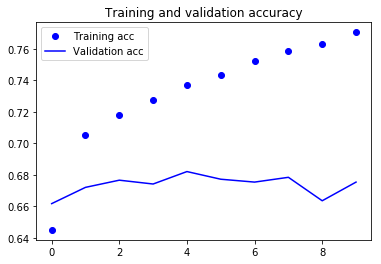

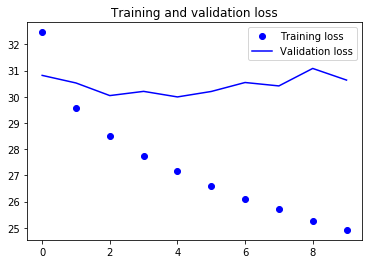

In [6]:
clear_session()

def create_cnn_model():
    cnn_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    cnn_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    cnn_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    cnn_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    cnn_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(cnn_team_input)
    cnn_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(cnn_oppo_team_input)
    cnn_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(cnn_player_input)

    cnn_concated_layers = layers.concatenate([cnn_team_layer, cnn_oppo_team_layer, cnn_player_layer, cnn_stats_input])

    cnn_conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(cnn_concated_layers)
    cnn_pool_layer_1 = layers.MaxPooling1D(2)(cnn_conv_layer_1)
    cnn_conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(cnn_pool_layer_1)
    cnn_pool_layer_2 = layers.GlobalMaxPooling1D()(cnn_conv_layer_2)
    cnn_output = layers.Dense(1)(cnn_pool_layer_2)

    cnn_model = models.Model(
        inputs=[
            cnn_team_input,
            cnn_oppo_team_input,
            cnn_player_input,
            cnn_stats_input
        ],
        outputs=cnn_output
    )
    cnn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return cnn_model


cnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_cnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

cnn_pipe.fit(X_train, y_train)

graph_model_history(cnn_pipe.steps[-1][1].model.history)

## CNN with dropout

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 3s 250us/step - loss: 33.0088 - tip_accuracy: 0.6323 - val_loss: 31.9674 - val_tip_accuracy: 0.6714
Epoch 2/20
13158/13158 [==============================] - 3s 201us/step - loss: 30.5075 - tip_accuracy: 0.6978 - val_loss: 31.8668 - val_tip_accuracy: 0.6742
Epoch 3/20
13158/13158 [==============================] - 3s 199us/step - loss: 29.5196 - tip_accuracy: 0.7075 - val_loss: 31.5997 - val_tip_accuracy: 0.6772
Epoch 4/20
13158/13158 [==============================] - 3s 194us/step - loss: 28.9825 - tip_accuracy: 0.7189 - val_loss: 32.0316 - val_tip_accuracy: 0.6708
Epoch 5/20
13158/13158 [==============================] - 2s 190us/step - loss: 28.5417 - tip_accuracy: 0.7232 - val_loss: 31.4609 - val_tip_accuracy: 0.6799
Epoch 6/20
13158/13158 [==============================] - 3s 196us/step - loss: 28.0326 - tip_accuracy: 0.7319 - val_loss: 32.1038 - val_tip_accuracy: 0.6535
Epo

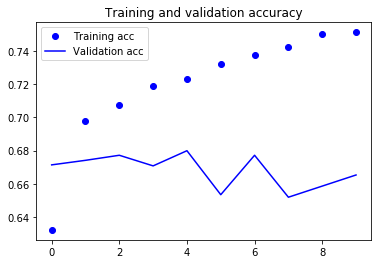

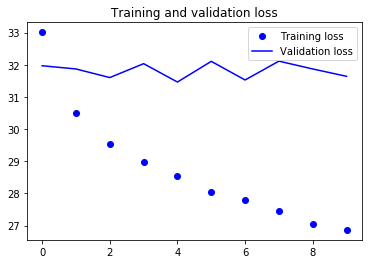

In [7]:
def create_do_model():
    do_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    do_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    do_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    do_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    do_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(do_team_input)
    do_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(do_oppo_team_input)
    do_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(do_player_input)

    do_concated_layers = layers.concatenate([do_team_layer, do_oppo_team_layer, do_player_layer, do_stats_input])

    do_conv_layer_1 = layers.Conv1D(32, 3, activation='relu')(do_concated_layers)
    do_dropout_layer_1 = layers.Dropout(rate=0.2)(do_conv_layer_1)

    do_pool_layer_1 = layers.MaxPooling1D(2)(do_dropout_layer_1)
    do_dropout_layer_2 = layers.Dropout(rate=0.2)(do_pool_layer_1)

    do_conv_layer_2 = layers.Conv1D(32, 3, activation='relu')(do_dropout_layer_2)
    do_dropout_layer_3 = layers.Dropout(rate=0.4)(do_conv_layer_2)

    do_pool_layer_2 = layers.GlobalMaxPooling1D()(do_dropout_layer_3)
    do_dropout_layer_4 = layers.Dropout(rate=0.4)(do_pool_layer_2)

    do_output = layers.Dense(1)(do_dropout_layer_4)

    do_model = models.Model(
        inputs=[
            do_team_input,
            do_oppo_team_input,
            do_player_input,
            do_stats_input
        ],
        outputs=do_output
    )
    do_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])
    return do_model


do_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_do_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

do_pipe.fit(X_train, y_train)

graph_model_history(do_pipe.steps[-1][1].model.history)

## CNN with l2 regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 3s 229us/step - loss: 32.4782 - tip_accuracy: 0.6511 - val_loss: 30.9089 - val_tip_accuracy: 0.6696
Epoch 2/20
13158/13158 [==============================] - 2s 170us/step - loss: 29.6847 - tip_accuracy: 0.7046 - val_loss: 30.2465 - val_tip_accuracy: 0.6793
Epoch 3/20
13158/13158 [==============================] - 2s 171us/step - loss: 28.6054 - tip_accuracy: 0.7220 - val_loss: 30.4999 - val_tip_accuracy: 0.6739
Epoch 4/20
13158/13158 [==============================] - 3s 192us/step - loss: 27.9388 - tip_accuracy: 0.7275 - val_loss: 30.7943 - val_tip_accuracy: 0.6745
Epoch 5/20
13158/13158 [==============================] - 2s 174us/step - loss: 27.2891 - tip_accuracy: 0.7393 - val_loss: 30.5718 - val_tip_accuracy: 0.6766
Epoch 6/20
13158/13158 [==============================] - 2s 184us/step - loss: 26.7455 - tip_accuracy: 0.7456 - val_loss: 30.5346 - val_tip_accuracy: 0.6772
Epo

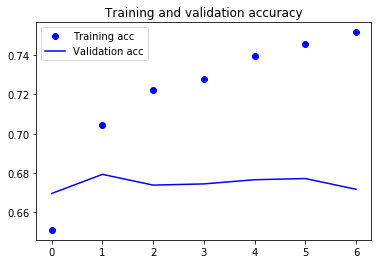

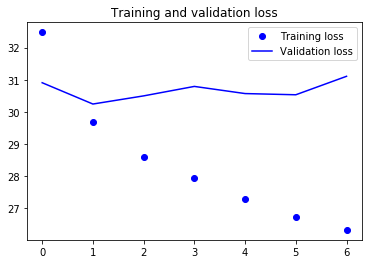

In [8]:
def create_l2_model():
    l2_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
    l2_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
    l2_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
    l2_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

    l2_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(l2_team_input)
    l2_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(l2_oppo_team_input)
    l2_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(l2_player_input)

    l2_concated_layers = layers.concatenate([l2_team_layer, l2_oppo_team_layer, l2_player_layer, l2_stats_input])

    l2_conv_layer_1 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(l2_concated_layers)
    l2_pool_layer_1 = layers.MaxPooling1D(2)(l2_conv_layer_1)
    l2_conv_layer_2 = layers.Conv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l2(0.002))(l2_pool_layer_1)
    l2_pool_layer_2 = layers.GlobalMaxPooling1D()(l2_conv_layer_2)
    l2_output = layers.Dense(1, kernel_regularizer=regularizers.l2(0.004))(l2_pool_layer_2)

    l2_model = models.Model(
        inputs=[
            l2_team_input,
            l2_oppo_team_input,
            l2_player_input,
            l2_stats_input
        ],
        outputs=l2_output
    )
    l2_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])
    return l2_model


l2_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_l2_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

l2_pipe.fit(X_train, y_train)

graph_model_history(l2_pipe.steps[-1][1].model.history)

## CNN performance by year

In [11]:
xgb_data = PlayerXGBData(train_years=(None, 2016), test_years=(None, None))
xgb_X, xgb_y = xgb_data.train_data()
xgb_estimator = PlayerXGB()

def yearly_performance_scores(estimators, features, labels):
    model_names = []
    errors = []
    accuracies = []
    years = []

    for year in range(2011, 2017):
        feat_train = features[features['year'] < year]
        feat_test = features[features['year'] == year]
        X_train = feat_train.values
        X_test = feat_test.values

        lab_train = labels.loc[feat_train.index]
        lab_test = labels.loc[feat_test.index]
        y_train = label_reshaper.transform(lab_train.values)[:, 0, :]
        y_test = label_reshaper.transform(lab_test.values)[:, 0, :]

        for estimator_name, estimator in estimators:
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test).reshape((-1, 1))

            years.append(year)
            model_names.append(estimator_name)
            errors.append(mean_absolute_error(y_test, y_pred))
            accuracies.append(regression_accuracy(y_test, y_pred))

    year_scores = pd.DataFrame({'model': model_names,
                                'year': years,
                                'error': errors,
                                'accuracy': accuracies}).astype({'year': int})
    
    return year_scores

def yearly_xgb_performance_scores(estimators, features, labels):
    model_names = []
    errors = []
    accuracies = []
    years = []

    for year in range(2011, 2017):
        X_train = features[features['year'] < year]
        X_test = features[features['year'] == year]

        y_train = labels.loc[X_train.index]
        y_test = labels.loc[X_test.index]

        for estimator_name, estimator in estimators:
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)

            years.append(year)
            model_names.append(estimator_name)
            errors.append(mean_absolute_error(y_test, y_pred))
            accuracies.append(regression_accuracy(y_test, y_pred))

    xgb_year_scores = pd.DataFrame({'model': model_names,
                                    'year': years,
                                    'error': errors,
                                    'accuracy': accuracies}).astype({'year': int})
    
    return xgb_year_scores

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(['player_id', 'year'], group_keys=True)
/app/server/data_processors/feature_functions.py:524: FutureWarning: 'year' is both an index level and a column label.
Defau

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 5s 397us/step - loss: 32.5956 - tip_accuracy: 0.6376 - val_loss: 30.9358 - val_tip_accuracy: 0.6501
Epoch 2/20
11521/11521 [==============================] - 3s 248us/step - loss: 29.8762 - tip_accuracy: 0.6965 - val_loss: 31.5292 - val_tip_accuracy: 0.6407
Epoch 3/20
11521/11521 [==============================] - 3s 246us/step - loss: 28.8457 - tip_accuracy: 0.7126 - val_loss: 30.3220 - val_tip_accuracy: 0.6689
Epoch 4/20
11521/11521 [==============================] - 3s 253us/step - loss: 28.1076 - tip_accuracy: 0.7228 - val_loss: 30.6135 - val_tip_accuracy: 0.6647
Epoch 5/20
11521/11521 [==============================] - 3s 254us/step - loss: 27.4191 - tip_accuracy: 0.7291 - val_loss: 30.6575 - val_tip_accuracy: 0.6668
Epoch 6/20
11521/11521 [==============================] - 3s 263us/step - loss: 26.8123 - tip_accuracy: 0.7400 - val_loss: 30.7694 - val_tip_accuracy: 0.6591
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 5s 430us/step - loss: 33.5227 - tip_accuracy: 0.6059 - val_loss: 31.9371 - val_tip_accuracy: 0.6682
Epoch 2/20
11521/11521 [==============================] - 3s 267us/step - loss: 30.8074 - tip_accuracy: 0.6819 - val_loss: 31.5936 - val_tip_accuracy: 0.6689
Epoch 3/20
11521/11521 [==============================] - 3s 282us/step - loss: 29.7368 - tip_accuracy: 0.7021 - val_loss: 32.1942 - val_tip_accuracy: 0.6418
Epoch 4/20
11521/11521 [==============================] - 3s 273us/step - loss: 29.2409 - tip_accuracy: 0.7094 - val_loss: 31.7433 - val_tip_accuracy: 0.6657
Epoch 5/20
11521/11521 [==============================] - 3s 266us/step - loss: 28.7028 - tip_accuracy: 0.7197 - val_loss: 31.5678 - val_tip_accuracy: 0.6574
Epoch 6/20
11521/11521 [==============================] - 3s 267us/step - loss: 28.3466 - tip_accuracy: 0.7248 - val_loss: 31.5858 - val_tip_accuracy: 0.6491
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11521 samples, validate on 2881 samples
Epoch 1/20
11521/11521 [==============================] - 5s 419us/step - loss: 32.7368 - tip_accuracy: 0.6317 - val_loss: 31.4639 - val_tip_accuracy: 0.6477
Epoch 2/20
11521/11521 [==============================] - 3s 258us/step - loss: 29.9936 - tip_accuracy: 0.6919 - val_loss: 31.0356 - val_tip_accuracy: 0.6532
Epoch 3/20
11521/11521 [==============================] - 3s 268us/step - loss: 28.9300 - tip_accuracy: 0.7138 - val_loss: 30.6047 - val_tip_accuracy: 0.6647
Epoch 4/20
11521/11521 [==============================] - 3s 259us/step - loss: 28.1812 - tip_accuracy: 0.7262 - val_loss: 30.5513 - val_tip_accuracy: 0.6734
Epoch 5/20
11521/11521 [==============================] - 3s 251us/step - loss: 27.5884 - tip_accuracy: 0.7336 - val_loss: 30.7667 - val_tip_accuracy: 0.6637
Epoch 6/20
11521/11521 [==============================] - 3s 253us/step - loss: 27.1416 - tip_accuracy: 0.7412 - val_loss: 31.0686 - val_tip_accuracy: 0.6557
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 5s 435us/step - loss: 32.6008 - tip_accuracy: 0.6440 - val_loss: 30.4640 - val_tip_accuracy: 0.6658
Epoch 2/20
11835/11835 [==============================] - 3s 273us/step - loss: 29.7592 - tip_accuracy: 0.6979 - val_loss: 30.2020 - val_tip_accuracy: 0.6702
Epoch 3/20
11835/11835 [==============================] - 3s 256us/step - loss: 28.7294 - tip_accuracy: 0.7136 - val_loss: 30.3832 - val_tip_accuracy: 0.6712
Epoch 4/20
11835/11835 [==============================] - 3s 250us/step - loss: 27.9847 - tip_accuracy: 0.7266 - val_loss: 30.3226 - val_tip_accuracy: 0.6691
Epoch 5/20
11835/11835 [==============================] - 3s 244us/step - loss: 27.3946 - tip_accuracy: 0.7345 - val_loss: 30.8987 - val_tip_accuracy: 0.6654
Epoch 6/20
11835/11835 [==============================] - 3s 250us/step - loss: 26.7476 - tip_accuracy: 0.7440 - val_loss: 30.6027 - val_tip_accuracy: 0.6637
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 6s 467us/step - loss: 33.4485 - tip_accuracy: 0.6214 - val_loss: 31.9402 - val_tip_accuracy: 0.6600
Epoch 2/20
11835/11835 [==============================] - 3s 295us/step - loss: 30.8375 - tip_accuracy: 0.6831 - val_loss: 31.5044 - val_tip_accuracy: 0.6654
Epoch 3/20
11835/11835 [==============================] - 3s 279us/step - loss: 29.8260 - tip_accuracy: 0.7029 - val_loss: 31.7386 - val_tip_accuracy: 0.6607
Epoch 4/20
11835/11835 [==============================] - 4s 296us/step - loss: 29.2796 - tip_accuracy: 0.7135 - val_loss: 31.4415 - val_tip_accuracy: 0.6664
Epoch 5/20
11835/11835 [==============================] - 4s 308us/step - loss: 28.7565 - tip_accuracy: 0.7226 - val_loss: 32.0148 - val_tip_accuracy: 0.6495
Epoch 6/20
11835/11835 [==============================] - 3s 274us/step - loss: 28.3536 - tip_accuracy: 0.7252 - val_loss: 32.2178 - val_tip_accuracy: 0.6347
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 11835 samples, validate on 2959 samples
Epoch 1/20
11835/11835 [==============================] - 6s 483us/step - loss: 33.0348 - tip_accuracy: 0.6275 - val_loss: 30.7444 - val_tip_accuracy: 0.6681
Epoch 2/20
11835/11835 [==============================] - 3s 260us/step - loss: 30.0984 - tip_accuracy: 0.7003 - val_loss: 30.4551 - val_tip_accuracy: 0.6752
Epoch 3/20
11835/11835 [==============================] - 3s 258us/step - loss: 29.0338 - tip_accuracy: 0.7082 - val_loss: 31.4695 - val_tip_accuracy: 0.6519
Epoch 4/20
11835/11835 [==============================] - 3s 250us/step - loss: 28.3352 - tip_accuracy: 0.7223 - val_loss: 30.1220 - val_tip_accuracy: 0.6820
Epoch 5/20
11835/11835 [==============================] - 3s 257us/step - loss: 27.7391 - tip_accuracy: 0.7339 - val_loss: 30.2855 - val_tip_accuracy: 0.6739
Epoch 6/20
11835/11835 [==============================] - 3s 255us/step - loss: 27.2589 - tip_accuracy: 0.7424 - val_loss: 30.7690 - val_tip_accuracy: 0.6651
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 5s 451us/step - loss: 33.0387 - tip_accuracy: 0.6313 - val_loss: 30.4271 - val_tip_accuracy: 0.6657
Epoch 2/20
12166/12166 [==============================] - 3s 264us/step - loss: 29.7191 - tip_accuracy: 0.7024 - val_loss: 31.3336 - val_tip_accuracy: 0.6529
Epoch 3/20
12166/12166 [==============================] - 3s 276us/step - loss: 28.6834 - tip_accuracy: 0.7205 - val_loss: 30.7166 - val_tip_accuracy: 0.6660
Epoch 4/20
12166/12166 [==============================] - 3s 264us/step - loss: 27.8338 - tip_accuracy: 0.7299 - val_loss: 30.5406 - val_tip_accuracy: 0.6657
Epoch 5/20
12166/12166 [==============================] - 3s 277us/step - loss: 27.1835 - tip_accuracy: 0.7394 - val_loss: 30.5747 - val_tip_accuracy: 0.6706
Epoch 6/20
12166/12166 [==============================] - 4s 289us/step - loss: 26.6412 - tip_accuracy: 0.7514 - val_loss: 30.6614 - val_tip_accuracy: 0.6680


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 6s 506us/step - loss: 33.3277 - tip_accuracy: 0.6203 - val_loss: 32.0143 - val_tip_accuracy: 0.6644
Epoch 2/20
12166/12166 [==============================] - 4s 292us/step - loss: 30.9528 - tip_accuracy: 0.6876 - val_loss: 31.4412 - val_tip_accuracy: 0.6821
Epoch 3/20
12166/12166 [==============================] - 3s 281us/step - loss: 29.9258 - tip_accuracy: 0.7022 - val_loss: 31.3738 - val_tip_accuracy: 0.6788
Epoch 4/20
12166/12166 [==============================] - 4s 302us/step - loss: 29.2559 - tip_accuracy: 0.7149 - val_loss: 31.5760 - val_tip_accuracy: 0.6788
Epoch 5/20
12166/12166 [==============================] - 3s 275us/step - loss: 28.6045 - tip_accuracy: 0.7214 - val_loss: 31.3557 - val_tip_accuracy: 0.6765
Epoch 6/20
12166/12166 [==============================] - 3s 279us/step - loss: 28.2475 - tip_accuracy: 0.7277 - val_loss: 31.3023 - val_tip_accuracy: 0.6670
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12166 samples, validate on 3042 samples
Epoch 1/20
12166/12166 [==============================] - 6s 500us/step - loss: 32.7722 - tip_accuracy: 0.6468 - val_loss: 30.3730 - val_tip_accuracy: 0.6765
Epoch 2/20
12166/12166 [==============================] - 4s 290us/step - loss: 29.9463 - tip_accuracy: 0.7018 - val_loss: 31.4289 - val_tip_accuracy: 0.6532
Epoch 3/20
12166/12166 [==============================] - 4s 298us/step - loss: 28.9325 - tip_accuracy: 0.7144 - val_loss: 30.4786 - val_tip_accuracy: 0.6693
Epoch 4/20
12166/12166 [==============================] - 4s 289us/step - loss: 28.2329 - tip_accuracy: 0.7245 - val_loss: 30.7220 - val_tip_accuracy: 0.6637
Epoch 5/20
12166/12166 [==============================] - 3s 274us/step - loss: 27.6120 - tip_accuracy: 0.7357 - val_loss: 31.7197 - val_tip_accuracy: 0.6604
Epoch 6/20
12166/12166 [==============================] - 4s 291us/step - loss: 27.1199 - tip_accuracy: 0.7426 - val_loss: 31.0263 - val_tip_accuracy: 0.6644


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 6s 494us/step - loss: 32.4506 - tip_accuracy: 0.6468 - val_loss: 30.3121 - val_tip_accuracy: 0.6707
Epoch 2/20
12497/12497 [==============================] - 4s 286us/step - loss: 29.6094 - tip_accuracy: 0.7061 - val_loss: 30.3524 - val_tip_accuracy: 0.6675
Epoch 3/20
12497/12497 [==============================] - 3s 277us/step - loss: 28.5330 - tip_accuracy: 0.7198 - val_loss: 30.6127 - val_tip_accuracy: 0.6653
Epoch 4/20
12497/12497 [==============================] - 3s 268us/step - loss: 27.7802 - tip_accuracy: 0.7266 - val_loss: 30.2012 - val_tip_accuracy: 0.6755
Epoch 5/20
12497/12497 [==============================] - 4s 310us/step - loss: 27.1874 - tip_accuracy: 0.7371 - val_loss: 30.2401 - val_tip_accuracy: 0.6714
Epoch 6/20
12497/12497 [==============================] - 3s 243us/step - loss: 26.5954 - tip_accuracy: 0.7424 - val_loss: 30.5191 - val_tip_accuracy: 0.6611
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 6s 498us/step - loss: 33.1763 - tip_accuracy: 0.6286 - val_loss: 31.9381 - val_tip_accuracy: 0.6627
Epoch 2/20
12497/12497 [==============================] - 4s 294us/step - loss: 30.7322 - tip_accuracy: 0.6903 - val_loss: 31.6594 - val_tip_accuracy: 0.6694
Epoch 3/20
12497/12497 [==============================] - 3s 273us/step - loss: 29.7971 - tip_accuracy: 0.7058 - val_loss: 31.8547 - val_tip_accuracy: 0.6624
Epoch 4/20
12497/12497 [==============================] - 4s 290us/step - loss: 29.1914 - tip_accuracy: 0.7150 - val_loss: 31.3560 - val_tip_accuracy: 0.6851
Epoch 5/20
12497/12497 [==============================] - 4s 308us/step - loss: 28.7571 - tip_accuracy: 0.7199 - val_loss: 31.7415 - val_tip_accuracy: 0.6672
Epoch 6/20
12497/12497 [==============================] - 4s 311us/step - loss: 28.1026 - tip_accuracy: 0.7325 - val_loss: 31.4148 - val_tip_accuracy: 0.6794
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12497 samples, validate on 3125 samples
Epoch 1/20
12497/12497 [==============================] - 6s 491us/step - loss: 32.7665 - tip_accuracy: 0.6480 - val_loss: 30.4366 - val_tip_accuracy: 0.6643
Epoch 2/20
12497/12497 [==============================] - 4s 283us/step - loss: 29.8236 - tip_accuracy: 0.7041 - val_loss: 31.0202 - val_tip_accuracy: 0.6582
Epoch 3/20
12497/12497 [==============================] - 3s 280us/step - loss: 28.8313 - tip_accuracy: 0.7141 - val_loss: 30.8808 - val_tip_accuracy: 0.6685
Epoch 4/20
12497/12497 [==============================] - 4s 300us/step - loss: 28.0829 - tip_accuracy: 0.7279 - val_loss: 30.2368 - val_tip_accuracy: 0.6765
Epoch 5/20
12497/12497 [==============================] - 4s 289us/step - loss: 27.5374 - tip_accuracy: 0.7327 - val_loss: 32.1100 - val_tip_accuracy: 0.6464
Epoch 6/20
12497/12497 [==============================] - 4s 286us/step - loss: 27.0368 - tip_accuracy: 0.7401 - val_loss: 31.3174 - val_tip_accuracy: 0.6637
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 7s 510us/step - loss: 32.4840 - tip_accuracy: 0.6441 - val_loss: 30.8633 - val_tip_accuracy: 0.6652
Epoch 2/20
12828/12828 [==============================] - 4s 295us/step - loss: 29.6126 - tip_accuracy: 0.7019 - val_loss: 30.3938 - val_tip_accuracy: 0.6724
Epoch 3/20
12828/12828 [==============================] - 3s 268us/step - loss: 28.6073 - tip_accuracy: 0.7164 - val_loss: 30.3058 - val_tip_accuracy: 0.6743
Epoch 4/20
12828/12828 [==============================] - 4s 275us/step - loss: 27.7747 - tip_accuracy: 0.7264 - val_loss: 30.0556 - val_tip_accuracy: 0.6761
Epoch 5/20
12828/12828 [==============================] - 4s 296us/step - loss: 27.2245 - tip_accuracy: 0.7370 - val_loss: 30.2299 - val_tip_accuracy: 0.6764
Epoch 6/20
12828/12828 [==============================] - 4s 322us/step - loss: 26.5771 - tip_accuracy: 0.7445 - val_loss: 31.4835 - val_tip_accuracy: 0.6596
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 7s 514us/step - loss: 33.4312 - tip_accuracy: 0.6208 - val_loss: 32.3187 - val_tip_accuracy: 0.6540
Epoch 2/20
12828/12828 [==============================] - 4s 300us/step - loss: 30.7273 - tip_accuracy: 0.6892 - val_loss: 31.8932 - val_tip_accuracy: 0.6593
Epoch 3/20
12828/12828 [==============================] - 4s 302us/step - loss: 29.7752 - tip_accuracy: 0.7065 - val_loss: 32.0807 - val_tip_accuracy: 0.6506
Epoch 4/20
12828/12828 [==============================] - 4s 337us/step - loss: 29.0461 - tip_accuracy: 0.7155 - val_loss: 31.8244 - val_tip_accuracy: 0.6646
Epoch 5/20
12828/12828 [==============================] - 4s 317us/step - loss: 28.5959 - tip_accuracy: 0.7254 - val_loss: 31.5346 - val_tip_accuracy: 0.6767
Epoch 6/20
12828/12828 [==============================] - 4s 308us/step - loss: 28.2480 - tip_accuracy: 0.7287 - val_loss: 31.2773 - val_tip_accuracy: 0.6730
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 12828 samples, validate on 3208 samples
Epoch 1/20
12828/12828 [==============================] - 7s 552us/step - loss: 32.7092 - tip_accuracy: 0.6458 - val_loss: 30.8717 - val_tip_accuracy: 0.6655
Epoch 2/20
12828/12828 [==============================] - 4s 303us/step - loss: 29.8300 - tip_accuracy: 0.6999 - val_loss: 31.2723 - val_tip_accuracy: 0.6655
Epoch 3/20
12828/12828 [==============================] - 4s 299us/step - loss: 28.8196 - tip_accuracy: 0.7170 - val_loss: 30.2130 - val_tip_accuracy: 0.6789
Epoch 4/20
12828/12828 [==============================] - 4s 277us/step - loss: 28.1133 - tip_accuracy: 0.7251 - val_loss: 30.4323 - val_tip_accuracy: 0.6824
Epoch 5/20
12828/12828 [==============================] - 4s 287us/step - loss: 27.4906 - tip_accuracy: 0.7356 - val_loss: 30.5493 - val_tip_accuracy: 0.6752
Epoch 6/20
12828/12828 [==============================] - 4s 304us/step - loss: 26.9904 - tip_accuracy: 0.7425 - val_loss: 31.2650 - val_tip_accuracy: 0.6665
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 7s 538us/step - loss: 32.5312 - tip_accuracy: 0.6440 - val_loss: 30.8052 - val_tip_accuracy: 0.6626
Epoch 2/20
13158/13158 [==============================] - 4s 307us/step - loss: 29.5677 - tip_accuracy: 0.7057 - val_loss: 30.4332 - val_tip_accuracy: 0.6748
Epoch 3/20
13158/13158 [==============================] - 4s 289us/step - loss: 28.5365 - tip_accuracy: 0.7164 - val_loss: 30.1075 - val_tip_accuracy: 0.6736
Epoch 4/20
13158/13158 [==============================] - 4s 294us/step - loss: 27.6846 - tip_accuracy: 0.7301 - val_loss: 30.2166 - val_tip_accuracy: 0.6729
Epoch 5/20
13158/13158 [==============================] - 4s 284us/step - loss: 27.0627 - tip_accuracy: 0.7377 - val_loss: 32.9788 - val_tip_accuracy: 0.6383
Epoch 6/20
13158/13158 [==============================] - 4s 290us/step - loss: 26.5329 - tip_accuracy: 0.7418 - val_loss: 30.8193 - val_tip_accuracy: 0.6681
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 7s 562us/step - loss: 33.2247 - tip_accuracy: 0.6205 - val_loss: 31.9912 - val_tip_accuracy: 0.6614
Epoch 2/20
13158/13158 [==============================] - 4s 331us/step - loss: 30.4393 - tip_accuracy: 0.6926 - val_loss: 31.7388 - val_tip_accuracy: 0.6745
Epoch 3/20
13158/13158 [==============================] - 4s 318us/step - loss: 29.6563 - tip_accuracy: 0.7066 - val_loss: 31.5222 - val_tip_accuracy: 0.6802
Epoch 4/20
13158/13158 [==============================] - 4s 320us/step - loss: 28.9202 - tip_accuracy: 0.7180 - val_loss: 31.6887 - val_tip_accuracy: 0.6766
Epoch 5/20
13158/13158 [==============================] - 4s 330us/step - loss: 28.6305 - tip_accuracy: 0.7230 - val_loss: 31.5691 - val_tip_accuracy: 0.6663
Epoch 6/20
13158/13158 [==============================] - 4s 323us/step - loss: 28.2287 - tip_accuracy: 0.7307 - val_loss: 31.7682 - val_tip_accuracy: 0.6617
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 7s 518us/step - loss: 32.6003 - tip_accuracy: 0.6519 - val_loss: 30.5008 - val_tip_accuracy: 0.6733
Epoch 2/20
13158/13158 [==============================] - 4s 281us/step - loss: 29.7521 - tip_accuracy: 0.7028 - val_loss: 30.4863 - val_tip_accuracy: 0.6742
Epoch 3/20
13158/13158 [==============================] - 4s 280us/step - loss: 28.6696 - tip_accuracy: 0.7193 - val_loss: 30.0493 - val_tip_accuracy: 0.6815
Epoch 4/20
13158/13158 [==============================] - 4s 288us/step - loss: 27.9061 - tip_accuracy: 0.7323 - val_loss: 30.1771 - val_tip_accuracy: 0.6836
Epoch 5/20
13158/13158 [==============================] - 4s 332us/step - loss: 27.3437 - tip_accuracy: 0.7390 - val_loss: 30.7350 - val_tip_accuracy: 0.6736
Epoch 6/20
13158/13158 [==============================] - 4s 281us/step - loss: 26.8289 - tip_accuracy: 0.7468 - val_loss: 30.7211 - val_tip_accuracy: 0.6742
Epo

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


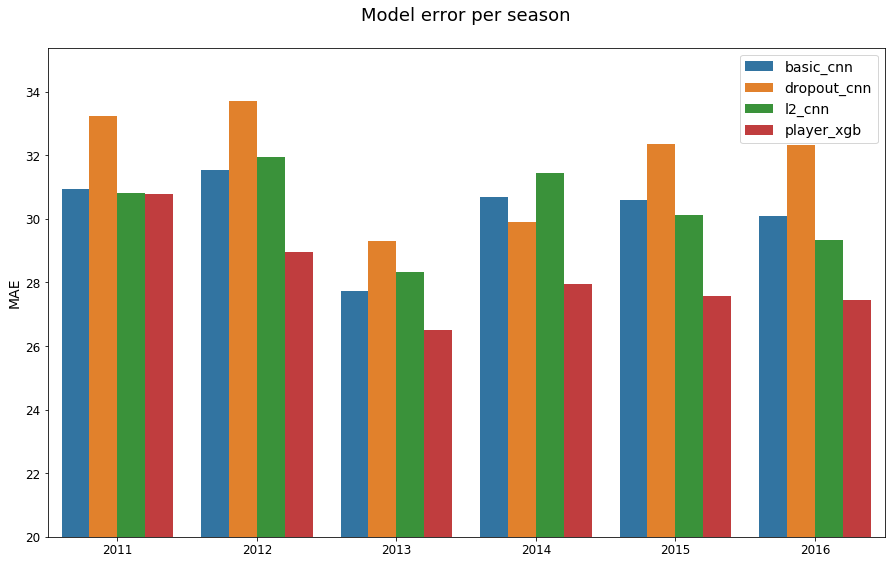

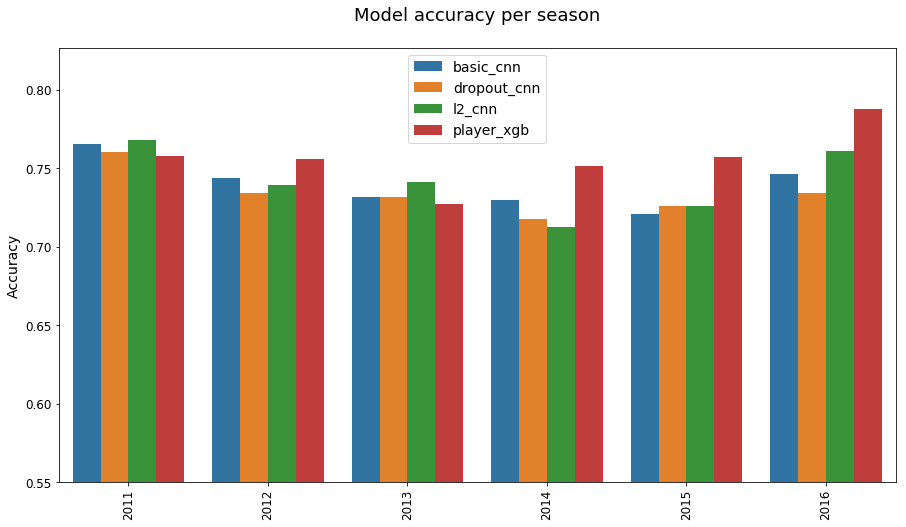

,accuracy,error,model,year
0,0.765306,30.942052,basic_cnn,2011
1,0.760204,33.236546,dropout_cnn,2011
2,0.767857,30.810086,l2_cnn,2011
3,0.743961,31.526737,basic_cnn,2012
4,0.734300,33.704937,dropout_cnn,2012
5,0.739130,31.960230,l2_cnn,2012
6,0.731884,27.718859,basic_cnn,2013
7,0.731884,29.290634,dropout_cnn,2013
8,0.741546,28.326232,l2_cnn,2013
9,0.729469,30.703813,basic_cnn,2014


In [12]:
estimators = [('basic_cnn', cnn_pipe), ('dropout_cnn', do_pipe), ('l2_cnn', l2_pipe)]
year_scores = pd.concat([yearly_performance_scores(estimators, features, labels),
                         yearly_xgb_performance_scores([('player_xgb', xgb_estimator)], xgb_X, xgb_y)],
                        sort=True)

graph_yearly_model_performance(year_scores)

year_scores

### XGB with aggregation still has the best performance

The basic & l2 regularized CNNs are comparable, but XGBoost performs better on both MAE & accuracy for most years.

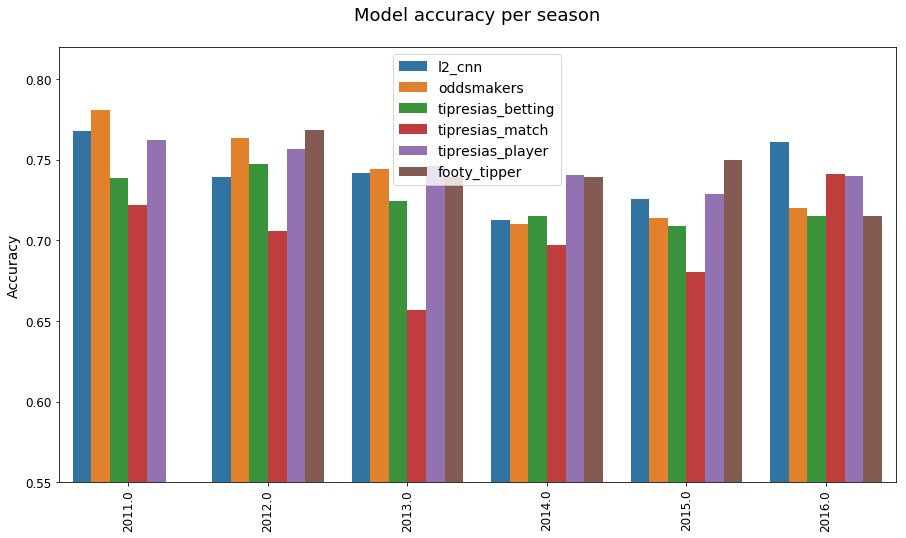

In [13]:
prediction_df = pd.read_csv('../data/model_predictions.csv')
prediction_scores = (prediction_df
                     .groupby(['model', 'year'])
                     .mean()['tip_point']
                     .reset_index()
                     .rename(columns={'tip_point': 'accuracy'}))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

all_year_scores = (pd
                   .concat([year_scores[year_scores['model'] == 'l2_cnn'],
                            prediction_scores,
                            footy_tipper_scores], sort=True)
                   .reset_index(drop=True))

graph_yearly_model_performance(all_year_scores[all_year_scores['year'] > 2010], error=False)

## Basic RNN

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 13158 samples, validate on 3290 samples
Epoch 1/20
13158/13158 [==============================] - 33s 2ms/step - loss: 33.8771 - tip_accuracy: 0.6238 - val_loss: 31.3472 - val_tip_accuracy: 0.6772
Epoch 2/20
13158/13158 [==============================] - 28s 2ms/step - loss: 31.5463 - tip_accuracy: 0.6788 - val_loss: 30.8318 - val_tip_accuracy: 0.6769
Epoch 3/20
13158/13158 [==============================] - 29s 2ms/step - loss: 30.6089 - tip_accuracy: 0.6936 - val_loss: 30.6679 - val_tip_accuracy: 0.6827
Epoch 4/20
13158/13158 [==============================] - 29s 2ms/step - loss: 29.9359 - tip_accuracy: 0.7092 - val_loss: 31.2113 - val_tip_accuracy: 0.6729
Epoch 5/20
13158/13158 [==============================] - 29s 2ms/step - loss: 29.3739 - tip_accuracy: 0.7155 - val_loss: 30.8222 - val_tip_accuracy: 0.6733
Epoch 6/20
13158/13158 [==============================] - 28s 2ms/step - loss: 29.0018 - tip_accuracy: 0.7205 - val_loss: 31.0121 - val_tip_accuracy: 0.6644
Epoch 7/2

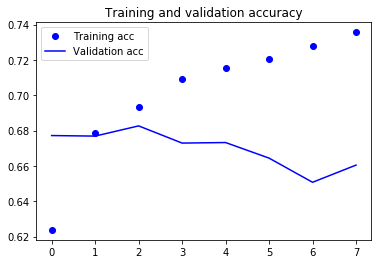

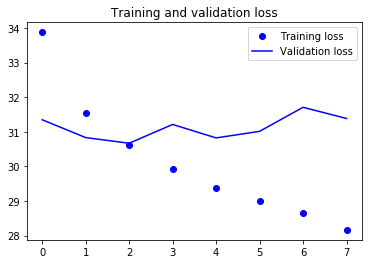

In [14]:
rnn_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='team')
rnn_oppo_team_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='oppo_team')
rnn_player_input = layers.Input(shape=(n_players_per_team_match,), dtype='int32', name='player')
rnn_stats_input = layers.Input(shape=(n_players_per_team_match, n_features - 3), dtype='float32', name='stats')

rnn_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(rnn_team_input)
rnn_oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=n_players_per_team_match)(rnn_oppo_team_input)
rnn_player_layer = layers.Embedding(max_player_id + max_min_diff + 1, 4, input_length=n_players_per_team_match)(rnn_player_input)

rnn_concated_layers = layers.concatenate([rnn_team_layer, rnn_oppo_team_layer, rnn_player_layer, rnn_stats_input])

lstm_1 = layers.LSTM(50, dropout=0.2, return_sequences=True)(rnn_concated_layers)
lstm_2 = layers.LSTM(50, dropout=0.2, return_sequences=True)(lstm_1)
lstm_3 = layers.LSTM(50, dropout=0.2)(lstm_2)
rnn_output = layers.Dense(1, activation='linear')(lstm_3)

rnn_model = models.Model(
    inputs=[
        rnn_team_input,
        rnn_oppo_team_input,
        rnn_player_input,
        rnn_stats_input
    ],
    outputs=rnn_output
)

rnn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

rnn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    DimensionReshaper((-1, n_players_per_team_match, n_features)),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=lambda: rnn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

rnn_pipe.fit(X_train, y_train)

graph_model_history(rnn_pipe.steps[-1][1].model.history)